## Active Learning Notebook
This notebook will suggest `k` images for annotation based on ensemble uncertainty and similarity between uncertain images. 

In [84]:
# Load Images
import numpy as np
imgs = np.load('active_unann_pool.npz') # Change this if your image pool is somewhere else
X = imgs['X']

# Convert to grayscale
red = X[:, :, :, 0]                                                                                                                
green = X[:, :, :, 1]                                                                                                              
blue = X[:, :, :, 2]                                                                                                               

gray = (                                                                                                                  
    0.299 * red                                                                                                                    
    + 0.587 * green                                                                                                                
    + 0.114 * blue)                                                                                                                

X = np.expand_dims(gray, axis=-1)
num_imgs = X.shape[0]

### Run PCA on images
First we need to reshape our images, then we will run PCA and transform the images down to the 95% explained variance point. This `d` dimensional vector will give a good way to compare images once we need to measure similarity.

In [2]:
# Reshape images
from functools import reduce
import operator

X_newshape = (X.shape[0], reduce(operator.mul, X.shape[1:], 1))
X_flat = np.reshape(X, X_newshape)

print('New shape for unannotated pool:', X_flat.shape)

New shape for unannotated pool: (2940, 65536)


In [3]:
from sklearn.decomposition import PCA
import time

# WARNING: You may need to use the incremental PCA class from sklearn if you run out of memory

print('Starting PCA on images...')
t1 = time.perf_counter()
color_pca = PCA(n_components=0.95)
X_proj = color_pca.fit_transform(X_flat)
t2 = time.perf_counter()
print(f'PCA on images took {t2 - t1:0.4f} seconds')
print('95% explained variance dimension:', X_proj.shape[1])

Starting PCA on images...
PCA on images took 58.5657 seconds
95% explained variance dimension: 208


### Predict Annotations
Now that we have a representation of images for similarity metrics, the next step is to run the images through all of the models. 

In [4]:
# Load and run each model on the images. Save just the predicted annotation
import os
from tensorflow import keras
from deepcell import model_zoo

models_dir = '../training/data/models/active_s1'
model_names = os.listdir(models_dir)

# TODO: This assumes something about the structure of the network... Is there a way to save the network structure?
model_names = list(filter(lambda x: True if '.h5' in x else False, model_names)) # get just the names that are h5 weight archives

receptive_field = 127
n_skips = 3

# We'll use this same model for all iterations, just with swapped weights
fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2, # foreground, background (i.e. cell, not cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=64,
    n_dense_filters=128,
    input_shape=tuple(X.shape[1:]),
    last_only=False
)

# To keep RAM usage down, it may be beneficial to run 100 or so images through each model, 
# then calculate uncertainty.
# This way, we don't need to store N copies of our whole image pool....
pixelwise_uncertainty = np.zeros(X.shape[:-1])
gran = 10

t1 = time.perf_counter()
for n in range(0, X.shape[0], gran):
    images = X[n:n+gran] if n + gran <= X.shape[0] else X[n:]
    predictions = np.zeros(tuple([len(model_names)]) + images.shape[:-1] + tuple([2]))
    for i, mp in enumerate(model_names):
        fgbg_model.load_weights(os.path.join(models_dir, mp))
        predictions[i] = fgbg_model.predict(images)[-1] 
    uncertainty = np.sum(np.var(predictions, axis=0), axis=-1) # calculate variance across all classes and sum
    if n + 10 <= X.shape[0]:
        pixelwise_uncertainty[n:n+gran] = uncertainty.copy()
    else:
        pixelwise_uncertainty[n:] = uncertainty.copy()
    
    t2 = time.perf_counter()
    print(gran + n, 'of', X.shape[0], f'images done in {t2 - t1:0.2f} seconds...')

10 of 2940 images done in 12.5271 seconds...
20 of 2940 images done in 15.8897 seconds...
30 of 2940 images done in 19.2418 seconds...
40 of 2940 images done in 22.6076 seconds...
50 of 2940 images done in 25.9675 seconds...
60 of 2940 images done in 29.3361 seconds...
70 of 2940 images done in 32.6995 seconds...
80 of 2940 images done in 36.0669 seconds...
90 of 2940 images done in 39.4302 seconds...
100 of 2940 images done in 42.8022 seconds...
110 of 2940 images done in 46.1736 seconds...
120 of 2940 images done in 49.6416 seconds...
130 of 2940 images done in 53.0232 seconds...
140 of 2940 images done in 56.4098 seconds...
150 of 2940 images done in 59.7914 seconds...
160 of 2940 images done in 63.1838 seconds...
170 of 2940 images done in 66.5661 seconds...
180 of 2940 images done in 69.9578 seconds...
190 of 2940 images done in 73.3426 seconds...
200 of 2940 images done in 76.7398 seconds...
210 of 2940 images done in 80.1322 seconds...
220 of 2940 images done in 83.5344 seconds.

1730 of 2940 images done in 603.1434 seconds...
1740 of 2940 images done in 606.5873 seconds...
1750 of 2940 images done in 610.0200 seconds...
1760 of 2940 images done in 613.4612 seconds...
1770 of 2940 images done in 616.9002 seconds...
1780 of 2940 images done in 620.3395 seconds...
1790 of 2940 images done in 623.7767 seconds...
1800 of 2940 images done in 627.2141 seconds...
1810 of 2940 images done in 630.6447 seconds...
1820 of 2940 images done in 634.0852 seconds...
1830 of 2940 images done in 637.6007 seconds...
1840 of 2940 images done in 641.0328 seconds...
1850 of 2940 images done in 644.4509 seconds...
1860 of 2940 images done in 647.8830 seconds...
1870 of 2940 images done in 651.3058 seconds...
1880 of 2940 images done in 654.7388 seconds...
1890 of 2940 images done in 658.1575 seconds...
1900 of 2940 images done in 661.5888 seconds...
1910 of 2940 images done in 665.0170 seconds...
1920 of 2940 images done in 668.4538 seconds...
1930 of 2940 images done in 671.8771 sec

### Variance Plots
Here we plot a couple of images with their variance heatmaps to get a visual feel of what the network is uncertain on. We also plot the mean variance in each image as a function of the image number.

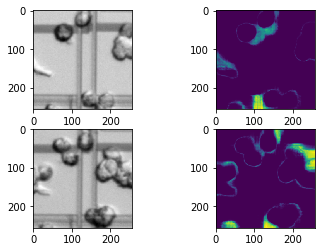

In [110]:
import random
# Show two random images and variance 
idx1 = random.randint(0, pixelwise_uncertainty.shape[0])
idx2 = random.randint(0, pixelwise_uncertainty.shape[0])
idx3 = random.randint(0, pixelwise_uncertainty.shape[0])
idx4 = random.randint(0, pixelwise_uncertainty.shape[0])

plt.subplot(222)
plt.imshow(pixelwise_uncertainty[idx1])
plt.subplot(221)
plt.imshow(np.squeeze(X[idx1]), cmap='gray')

plt.subplot(224)
plt.imshow(pixelwise_uncertainty[idx2])
plt.subplot(223)
plt.imshow(np.squeeze(X[idx2]), cmap='gray')

plt.show()

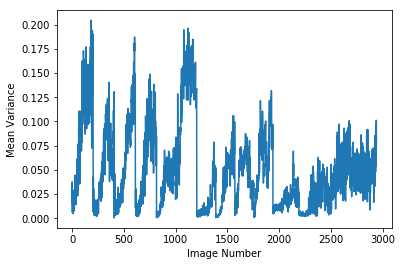

In [111]:
# Per image uncertainty is the mean uncertainty of all pixels in the image
mean_newshape = (pixelwise_uncertainty.shape[0], reduce(operator.mul, pixelwise_uncertainty.shape[1:], 1))
imagewise_uncertainty = np.mean(np.reshape(pixelwise_uncertainty, mean_newshape), axis=1)

import matplotlib.pyplot as plt
plt.plot(imagewise_uncertainty)
plt.xlabel('Image Number')
plt.ylabel('Mean Variance')
plt.show()

### Suggest Annotations
Annotation Suggestion, once the uncertainties are calculated, takes three steps:
1. Find the K most uncertain images
2. Calculate the pairwise similarities of those K images with all images in the pool
3. Use those similarities to greedily approximate a k-subset of the K images that is most representative of the pool

In [77]:
# Find the top K most uncertain images
K = 100
Sc = [] # Candidate set
tmp = imagewise_uncertainty.copy()
for i in range(K):
    idx = np.argmax(tmp)
    Sc.append(idx)
    tmp[idx] = 0
print(Sc)

[182, 1122, 1079, 196, 1128, 200, 186, 1126, 604, 203, 1167, 1165, 1169, 1124, 1168, 602, 1125, 1107, 1154, 1166, 1161, 136, 177, 1156, 1141, 1118, 194, 1163, 199, 197, 1134, 110, 198, 1080, 1103, 603, 201, 1162, 1129, 1086, 1116, 1123, 1082, 1094, 1160, 195, 1132, 1085, 1110, 1138, 111, 1164, 1131, 179, 180, 1081, 1084, 114, 1092, 185, 1159, 98, 1099, 1120, 1102, 117, 1087, 1192, 595, 1133, 1088, 1137, 1155, 143, 1176, 1117, 1127, 1104, 166, 160, 1096, 1078, 187, 1157, 1111, 148, 1074, 1149, 1109, 1136, 1069, 1146, 193, 1113, 174, 1114, 178, 1057, 1066, 1105]


In [78]:
# Compute all of the cross similarities
t1 = time.perf_counter()
sims = np.zeros((K, X_proj.shape[0])) # K x num_imgs array
for i in range(K):
    I_Sc = np.expand_dims(X_proj[Sc[i]], 0)
    
    for j in range(X_proj.shape[0]):
        I_Sa = np.expand_dims(X_proj[j], 0)
        sims[i][j] = abs(cosine_similarity(I_Sc, I_Sa)[0][0])
        
t2 = time.perf_counter()
print(K, f"sets of cross similarities computed in {t2 - t1:0.4f} seconds...")


100 sets of cross similarities computed in 32.7031 seconds...


In [97]:
# Assumes that sims is |Sc| x |Su| array of cosine similarities.
def F_presims(Sa, sims):
    rep = 0
    for x in range(sims.shape[1]):
        rep = rep + max([sims[i][x] for i in Sa])
    return rep

# Find a k-subset (k < K) of K_uncertain that 
# is the most representative of the full image pool
k = 50
Sa = [] # Suggested Annotation set
Sc_idxs = list(range(len(Sc)))
t1 = time.perf_counter()
for i in range(k):
    max_rep = 0
    max_rep_idx = 0
    
    # Find the maximum marginal representativeness by adding the 
    # remaining images to the set one at a time
    for idx in Sc_idxs: 
        Sa_tmp = Sa + [idx]
        rep_tmp = F_presims(Sa_tmp, sims)
        if rep_tmp >= max_rep:
            max_rep = rep_tmp
            max_rep_idx = idx
    
    Sc_idxs.remove(max_rep_idx)
    Sa.append(max_rep_idx)
t2 = time.perf_counter()
print("Found representative subset of", k, f"images in {t2 - t1:0.2f} seconds")
Sa = [Sc[i] for i in Sa] # Change Sa from indicies of Sc to indices of Su

Found representative subset of 50 images in 45.95 seconds


### Save results
Remove the suggested annotations from the pool, then save the new pool and the suggested images.

In [95]:
# Remove suggested annotations from pool, then save the two new sets
X_color = imgs['X']

sanns = np.zeros(tuple([len(Sa)]) + X_color.shape[1:])
for i, idx in enumerate(Sa):
    sanns[i] = X_color[idx]

X_color = np.delete(X_color, Sa, axis=0)
np.savez('suggested_anns.npz', X=sanns, y=np.zeros(sanns.shape[:-1] + tuple([1])))
np.savez('new_unann_pool.npz', X=X_color, y=np.zeros(X_color.shape[:-1] + tuple([1])))